In [9]:
import pandas as pd

# Adding composition effects increases performance for specific GO Terms related to those cell types

In [10]:
# tissue = 'brain' # or pbmc
tissue = "pbmc"
path_to_melted_df = f"/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/data/boostrapped/1/EGAD/melted_dfs/{tissue}_sc_with_metadata_cpm_pc.h5ad_melted_df.csv.gz"
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/bp_curated_annotations.tsv"

In [11]:
df_brain_melted = pd.read_csv(path_to_melted_df, index_col = 0)

In [12]:
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
curated_gos.fillna("F", inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/bp_curated_annotations.tsv'

In [ ]:
def combine_bootstraps_to_avg(melted_df:pd.DataFrame) -> pd.DataFrame:
    """Combine the performance of GO terms across bootstraps

    Args:
        melted_df (pd.DataFrame): df of data for aucs across many bootstraps
    """
    avg_performance = melted_df.groupby('index').mean()
    avg_performance = avg_performance['auc']
    return avg_performance
    

In [5]:
def combine_with_go_metadata(df_auc_performance:pd.DataFrame, go_cta_df:pd.DataFrame)-> pd.DataFrame:
    """Combine the GO metadata to our gene information

    Args:
        df_auc_performance (_type_): performance of go terms
        go_cta (_type_): cell type affiliation of go curations

    Returns:
        pd.DataFrame: _description_
    """
    
    merged_data = pd.merge(df_auc_performance, go_cta_df, how = 'left', left_on='index', right_on='id')
    return merged_data

brain_annotations = combine_with_go_metadata(df_auc_performance=df_brain_melted,
                                             go_cta_df=curated_gos)
brain_annotations.head()

NameError: name 'curated_gos' is not defined

In [6]:
melted_df = brain_annotations.melt(id_vars=['id', 'auc', 'variance'],
                                   value_vars=['CTAffiliated', 'BrainAffiliated', 'PBMCAffiliated'])
melted_df.head()

NameError: name 'brain_annotations' is not defined

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named melted_df
# containing columns 'variance', 'auc', 'variable', 'value'

# Set a different color palette (e.g., 'Set2')
sns.set_palette('Set2')

# Use Seaborn to create a faceted boxplot separated by color
g = sns.FacetGrid(melted_df, col='variable', height=6, aspect=1.2)
g.map_dataframe(sns.boxplot, x='variance', y='auc', hue='value', dodge=True)

# Set labels and title
g.set_axis_labels('Variance Level', 'AUC')
g.fig.suptitle(f'{tissue}: Cell Type Related GO Term Performance Increases with Compositional Variance', y=1.02)

# Add legend outside the plot
g.add_legend(title='Legend', bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.show()


NameError: name 'melted_df' is not defined

In [ ]:
import pandas as pd

# Performance increases because adding composition effects increases correlations of genes in brain related GO terms

In [ ]:
#!/usr/bin/env python3

import pandas as pd

# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")


# First get a list of all of the GOs related to brains
lo_brain_related_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] == "T"].id


# Now get all of the genes in these brain GO terms
go_annot_brain = go_annot[go_annot.loc[:,"GO ID"].isin(lo_brain_related_gos)]
lo_brain_related_genes = go_annot_brain.ensembl_gene_id.unique()


# Load the experimental or control simulated bulk sample
pbmc_path = ""
brain_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0.01_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
sim_bulk = pd.read_csv(brain_path, index_col=0)


# get correlations
sim_bulk_corr = sim_bulk.T.corr()



In [8]:

import os,sys
import matplotlib.pylab as plt
import numpy as np
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi']=300
# plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
# plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
# plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
import fastcluster

# First, make a df of the annotations that I need.
df_annotations = pd.DataFrame(index=sim_bulk_corr.index, data={"brain": sim_bulk_corr.index.isin(lo_brain_related_genes)})
df_annotations['brain'] = df_annotations['brain'].replace({True: 'T', False: 'F'})


# Make annotations from df and plot
col_ha = pch.HeatmapAnnotation(df = df_annotations.iloc[0:100],
                               axis=1)

# row_ha = pch.HeatmapAnnotation(df = df_annotations.iloc[0:10], 
#                                axis = 0)

# Create linkage with fast cluster
linkage = fastcluster.linkage(sim_bulk_corr.iloc[0:100, 0:100], method='average', metric='canberra')

plt.figure(figsize=(30, 30))

cm = pch.ClusterMapPlotter(data=sim_bulk_corr.iloc[0:100, 0:100],
                           top_annotation = col_ha,
                        #    right_annotation = row_ha,
                            col_cluster=True,
                            row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5,# distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            col_dendrogram_kws=dict(linkage=linkage), # adds custom clustering via fastcluster
                            col_dendrogram=True
                            )

plt.savefig("example0.png", bbox_inches='tight')
plt.show()


NameError: name 'sim_bulk_corr' is not defined

## Okay... Lets look at the correlations of genes within one GO term

In [50]:
#!/usr/bin/env python3

import pandas as pd

# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")


# First get a list of all of the GOs related to brains
lo_brain_related_gos = curated_gos[curated_gos.loc[:,'PBMCAffiliated'] == "T"].id


# Now get all of the genes in these brain GO terms
go_annot_brain = go_annot[go_annot.loc[:,"GO ID"].isin(lo_brain_related_gos)]
lo_brain_related_genes = go_annot_brain.ensembl_gene_id.unique()




In [91]:
# Load the experimental or control simulated bulk sample
pbmc_path = ""
brain_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
sim_bulk = pd.read_csv(brain_path, index_col=0)


# get correlations
sim_bulk_corr = sim_bulk.T.corr()

In [92]:
lo_mean_corr_rows = []

for go, df in go_annot_brain.groupby("GO ID"):
    print(go)
    # print(df.ensembl_gene_id)
    sim_bulk_corr_go_term_subset = sim_bulk_corr.iloc[sim_bulk_corr.index.isin(df.ensembl_gene_id), sim_bulk_corr.index.isin(df.ensembl_gene_id)]
    sim_bulk_corr_non_go_term_subset = sim_bulk_corr.iloc[~sim_bulk_corr.index.isin(df.ensembl_gene_id), ~sim_bulk_corr.index.isin(df.ensembl_gene_id)]
    
    if sim_bulk_corr_go_term_subset.shape[0] <=3:
        continue
    
    # print(sim_bulk_corr_go_term_subset.mean().mean())
    # print(sim_bulk_corr_non_go_term_subset.mean().mean())
    print(sim_bulk_corr_go_term_subset.shape)
    print(sim_bulk_corr_non_go_term_subset.shape)
    
    
    mean_df_row = pd.DataFrame(data = {
                                "withinCorrMean": sim_bulk_corr_go_term_subset.mean().mean(),
                                "outCorrMean": sim_bulk_corr_non_go_term_subset.mean().mean()},
                               index = [go])
    lo_mean_corr_rows.append(mean_df_row)
    

GO:0001782
(25, 25)
(17699, 17699)
GO:0001817
(55, 55)
(17669, 17669)
GO:0001818
(29, 29)
(17695, 17695)
GO:0001819
(51, 51)
(17673, 17673)
GO:0001916
(18, 18)
(17706, 17706)
GO:0002218
(25, 25)
(17699, 17699)
GO:0002224
(23, 23)
(17701, 17701)
GO:0002227
(11, 11)
(17713, 17713)
GO:0002230
(27, 27)
(17697, 17697)
GO:0002250
(132, 132)
(17592, 17592)
GO:0002286
(14, 14)
(17710, 17710)
GO:0002376
(35, 35)
(17689, 17689)
GO:0002377
GO:0002437
(19, 19)
(17705, 17705)
GO:0002548
(26, 26)
(17698, 17698)
GO:0002639
(24, 24)
(17700, 17700)
GO:0002682
(34, 34)
(17690, 17690)
GO:0002862
(20, 20)
(17704, 17704)
GO:0006911
(21, 21)
(17703, 17703)
GO:0006953
(22, 22)
(17702, 17702)
GO:0006954
(339, 339)
(17385, 17385)
GO:0006955
(239, 239)
(17485, 17485)
GO:0006956
(17, 17)
(17707, 17707)
GO:0006958
(24, 24)
(17700, 17700)
GO:0006959
(41, 41)
(17683, 17683)
GO:0006968
(42, 42)
(17682, 17682)
GO:0007254
(51, 51)
(17673, 17673)
GO:0007596
(72, 72)
(17652, 17652)
GO:0010804
(17, 17)
(17707, 17707)
GO:

In [93]:
df_mean_corrs = pd.concat(lo_mean_corr_rows)

<Axes: xlabel='variable', ylabel='value'>

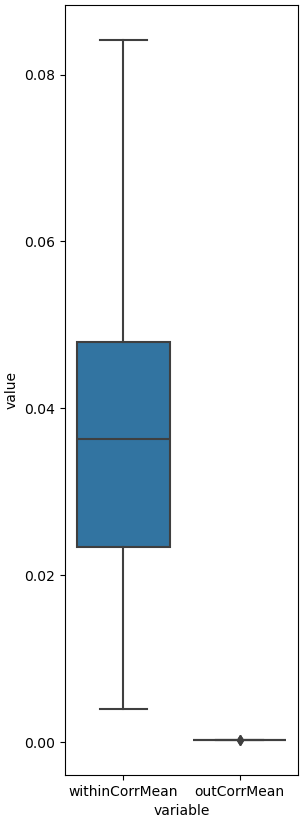

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(3, 10))  # Adjust width and height according to your needs


data = df_mean_corrs.melt()

sns.boxplot(data = data, x = 'variable', y = 'value')

In [95]:
df_mean_corrs.to_csv("mean_corrs_bulkbrain_var0_PBMCGOs.csv")

# Load each of the mean correlation dataframes and plot them



In [101]:
brain_0 = pd.read_csv("mean_corrs_bulkbrain_var0_brainGOs.csv", index_col=0)
brain_001 = pd.read_csv("mean_corrs_bulkbrain_var001_brainGOs.csv", index_col=0)
pbmc_0 = pd.read_csv('mean_corrs_bulkbrain_var0_PBMCGOs.csv', index_col=0)
pbmc_001 = pd.read_csv('mean_corrs_bulkbrain_var001_PBMCGOs.csv', index_col=0)

In [113]:
# add metadata column to each
brain_0['meta'] = 'brain'
brain_001['meta'] = 'brain'
pbmc_0['meta'] = 'pbmc'
pbmc_001['meta'] = 'pbmc'

brain_0['variance'] = 0
brain_001['variance'] = 0.01
pbmc_0['variance'] = 0
pbmc_001['variance'] = 0.01

In [114]:
# concat
corr_data_df = pd.concat([brain_0,brain_001, pbmc_0, pbmc_001], axis = 0)

In [139]:
corr_melted = corr_data_df.reset_index().melt(id_vars = ['index', 'meta','variance'])

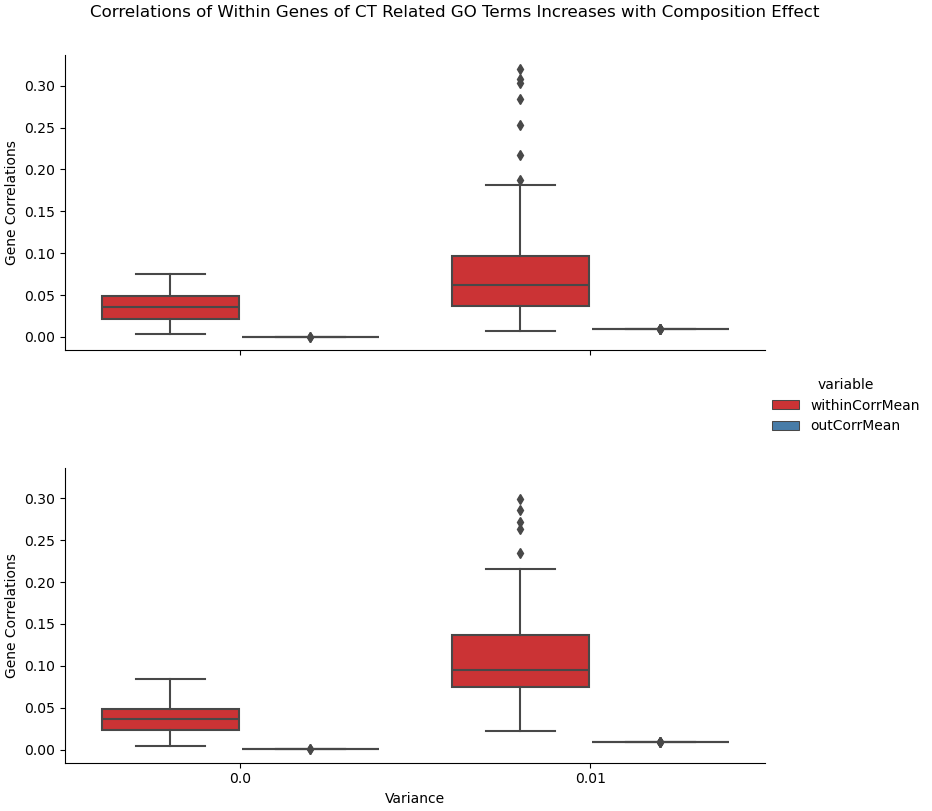

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
# ...

# Assuming 'meta' is a column in corr_melted
# Create a catplot with boxplot, facet by rows
g = sns.catplot(
    data=corr_melted,
    x='variance',
    y='value',
    hue='variable',
    kind='box',
    row='meta',  # Facet by rows
    height=4,    # Adjust the height of each facet
    aspect=2,    # Adjust the aspect ratio of each facet
    palette='Set1',  # Adjust the color palette
    
)


plt.suptitle('Correlations of Within Genes of CT Related GO Terms Increases with Composition Effect', y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
# Remove facet titles
g.set_titles("")
g.set_xlabels('Variance')
g.set_ylabels('Gene Correlations')

# Show the plot
plt.show()


# Show the correlation increase with composition effect via heatmap


In [1]:
#!/usr/bin/env python3

import pandas as pd

# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")


# First get a list of all of the GOs related to brains
lo_brain_related_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] == "T"].id


# Now get all of the genes in these brain GO terms
go_annot_brain = go_annot[go_annot.loc[:,"GO ID"].isin(lo_brain_related_gos)]
lo_brain_related_genes = go_annot_brain.ensembl_gene_id.unique()



# Plotting for Entire Brain Related Genes

correlating
calc clustering
clustering
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


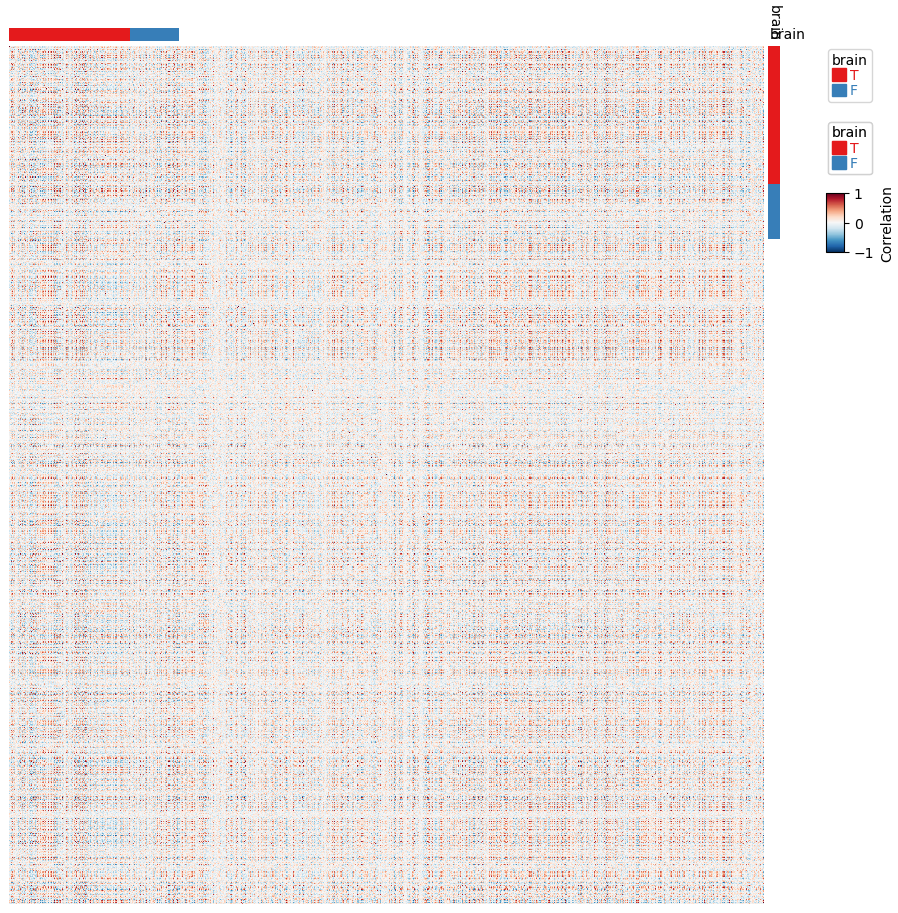

In [158]:

# Load the experimental or control simulated bulk sample
con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0.01_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"

sim_bulk_con = pd.read_csv(con_path, index_col=0)
sim_bulk_exp = pd.read_csv(exp_path, index_col=0)



def graph(sim_bulk, variance):
    import os,sys
    import matplotlib.pylab as plt
    import numpy as np
    # plt.rcParams['figure.dpi'] = 100
    # plt.rcParams['savefig.dpi']=300
    # plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
    # plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
    # plt.rcParams['pdf.fonttype']=42
    # sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
    import PyComplexHeatmap as pch
    import fastcluster
    
    print('correlating')
    # get correlations
    sim_bulk_corr = sim_bulk.T.corr()

    # First, make a df of the annotations that I need.
    df_annotations = pd.DataFrame(index=sim_bulk_corr.index, data={"brain": sim_bulk_corr.index.isin(lo_brain_related_genes)})
    df_annotations['brain'] = df_annotations['brain'].replace({True: 'T', False: 'F'})
    df_annotations = df_annotations.sort_values('brain', ascending=False) # df of annotatinos with all of the Trues at top

    # Make annotations from df and plot
    col_ha = pch.HeatmapAnnotation(df = df_annotations.iloc[0:4000],
                                axis=1)

    row_ha = pch.HeatmapAnnotation(df = df_annotations.iloc[0:4000], 
                                   axis = 0)
    
    # Sort sim_corr by the annotations sorting so all of the correlations between True brain related things are first
    sim_bulk_corr = sim_bulk_corr.reindex(df_annotations.index)
    sim_bulk_corr = sim_bulk_corr[df_annotations.index]
    
    # Get the mean correlation for the genes affiliated with brian functions and the correlation for all other genes

    print('calc clustering')
    # Create linkage with fast cluster
    linkage = fastcluster.linkage(sim_bulk_corr.iloc[0:4000,0:4000], method='average', metric='canberra')

    plt.figure(figsize=(10, 10))

    print('clustering')

    cm = pch.ClusterMapPlotter(data=sim_bulk_corr,
                            top_annotation = col_ha,
                               right_annotation = row_ha,
                                col_cluster=False,
                                row_cluster=False, # cluster rows and dols
                                label='Correlation', # Legend Name
                                # row_dendrogram=True,
                                show_rownames=False,show_colnames=False, # Do not show row or col names
                                cmap='RdBu_r', # set colors
                                verbose=0,
                                legend_gap = 5,# distance legend
                                vmin=-1,  # Set the minimum color value to -1
                                vmax=1,   # Set the maximum color value to 1
                                center=0,# center the cmap scale such that correlation of 0 is white
                                #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                                col_dendrogram_kws=dict(linkage=linkage), # adds custom clustering via fastcluster
                                row_dendrogram_kws=dict(linkage=linkage),
                                # col_dendrogram=False
                                )

    # plt.savefig(f"variance_{variance}_no_clustering.png", bbox_inches='tight')
    plt.show()


# graph(sim_bulk=sim_bulk_con.iloc[0:100,:], variance = 0)
graph(sim_bulk=sim_bulk_exp, variance = 0.01)

# Plotting for One specific GO Term


Here I am plotting the gene correlation for all of the genes within 1 GO term.

I Need to plot for correlatinos when there is composition effecst, and when there is not

In [ ]:
import matplotlib.pylab as plt
import numpy as np
from PyComplexHeatmap import *
import fastcluster


In [246]:
# Get the genes for specific GO term
specific_go = lo_brain_related_gos.iloc[-1]
lo_specific_go_genes = go_annot[go_annot.loc[:,"GO ID"] == specific_go].ensembl_gene_id
specific_go

'GO:2000463'

In [277]:
# # Load the experimental or control simulated bulk sample


# con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
# variance = 0
# sim_bulk= pd.read_csv(con_path, index_col=0)
# tissue = "Brain"

exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0.01_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
variance = 0.01
sim_bulk = pd.read_csv(exp_path, index_col=0)
tissue = "Brain"

# # Do for pbmc dataset
# pbmc_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/pbmc_sc_with_metadata_cpm_pc/var_0.01_pbmc_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz"
# variance = 0.01
# sim_bulk = pd.read_csv(pbmc_path, index_col=0)
# tissue = 'PBMC'

In [278]:
sim_bulk_corr = sim_bulk.T.corr()


In [279]:
# get a list of the integers we want to use from the correlation matrix
# it will be the GO term genes, as well as an amount of random genes
size = 200
lo_random_ints = np.random.choice(np.arange(start = len(lo_specific_go_genes), stop = (sim_bulk_corr.shape[0])), size = size, replace = False)

# Get the indexes of the GO term related genes
go_term_range = np.arange(0,len(lo_specific_go_genes))

lo_selected_ints = np.concatenate((go_term_range,lo_random_ints))

In [280]:
# First, make a df of the annotations that I need.
df_annotations = pd.DataFrame(index=sim_bulk_corr.index, data={"brain": sim_bulk_corr.index.isin(lo_specific_go_genes)})
df_annotations['brain'] = df_annotations['brain'].replace({True: 'T', False: 'F'})
df_annotations = df_annotations.sort_values('brain', ascending=False) # df of annotatinos with all of the Trues at top

In [281]:
# Make annotations from df and plot
col_ha = pch.HeatmapAnnotation(GO_Genes = anno_simple(df = df_annotations.iloc[lo_selected_ints],
                                                    add_text=False
                                                    ),
                               label_kws= {'visible':False},
                               legend=False,
                               axis = 1)
                                                     

row_ha = pch.HeatmapAnnotation(GO_Genes = anno_simple(df = df_annotations.iloc[lo_selected_ints],
                                                    add_text=False
                                                    ),
                               label_kws ={'visible':False},

                                # label_side='bottom',
                               legend=False,
                               axis = 0)

# Sort sim_corr by the annotations sorting so all of the correlations between True brain related things are first
sim_bulk_corr = sim_bulk_corr.reindex(df_annotations.index)
sim_bulk_corr = sim_bulk_corr[df_annotations.index]



# Get all the selected genes
sim_bulk_corr_subset = sim_bulk_corr.iloc[lo_selected_ints,lo_selected_ints]
# Documentation https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/kwargs.html


clustering
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


<Figure size 640x480 with 0 Axes>

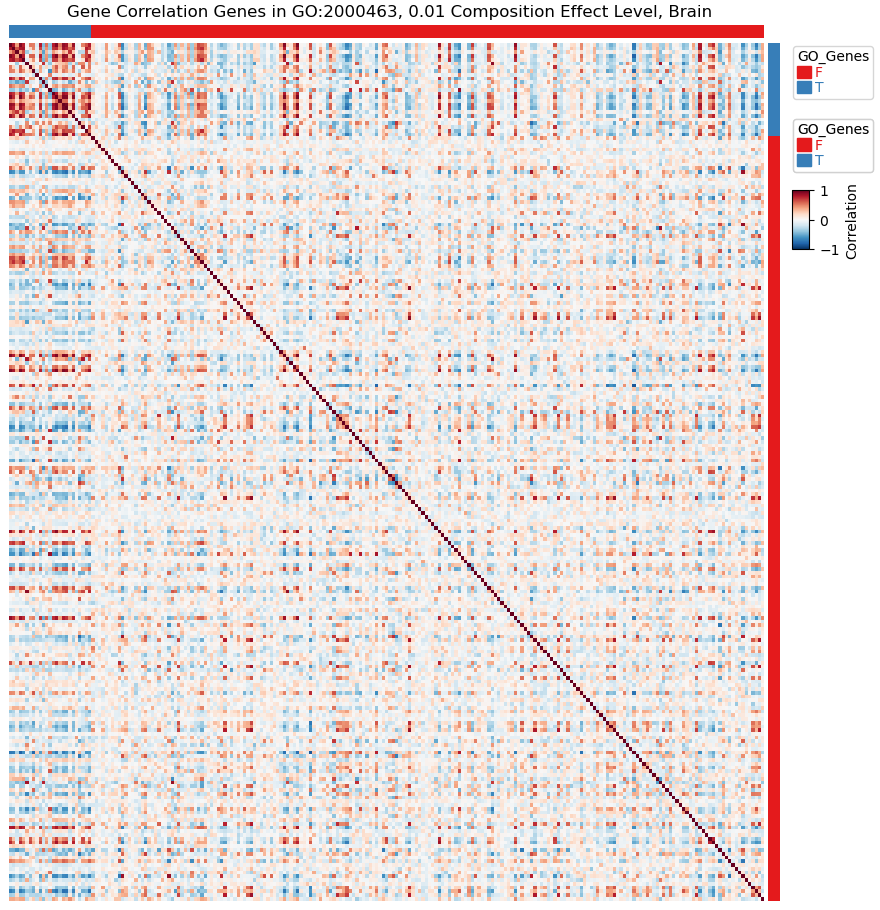

In [282]:
plt.clf()
plt.figure(figsize=(10, 10))
plt.title(f"Gene Correlation Genes in GO:2000463, {variance} Composition Effect Level, {tissue} ")
print('clustering')
# linkage = fastcluster.linkage(sim_bulk_corr.iloc[0:1000, 0:1000], method='average', metric='canberra')
# 
cm = pch.ClusterMapPlotter(data=sim_bulk_corr_subset,
                        top_annotation = col_ha,
                            right_annotation = row_ha,
                            col_cluster=False,
                            row_cluster=False, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5,# distance legend
                            vmin=-1,  # Set the minimum color value to -1
                            vmax=1,   # Set the maximum color value to 1
                            center=0,
                            # center the cmap scale such that correlation of 0 is white
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            # col_dendrogram_kws=dict(linkage=linkage), # adds custom clustering via fastcluster
                            # row_dendrogram_kws=dict(linkage=linkage),
                            # col_dendrogram=False
                            
                            )
# cm.ax.title("test")

plt.savefig(f"variance_{variance}_bulk{tissue}_GO:2000463'.png", bbox_inches='tight')
plt.show()
